In [9]:
%matplotlib inline

# Conditional clade probability summaries

## Edit primates data to four taxa

In [1]:
from Bio.Nexus.Nexus import Nexus

nexus = Nexus()
nexus.read('../data/Influenza.nexus')
nexus

In [2]:
nexus.taxlabels

['CY068129_A_California_VRDL396_2009_2009/04/28',
 'CY068870_A_California_VRDL392_2009_2009/04/28',
 'CY068686_A_California_VRDL181_2009_2009/04/28',
 'CY068137_A_California_VRDL159_2009_2009/04/28',
 'CY068217_A_California_VRDL173_2009_2009/04/28',
 'CY068702_A_California_VRDL184_2009_2009/04/28',
 'CY068742_A_California_VRDL199_2009_2009/04/28',
 'CY068766_A_California_VRDL204_2009_2009/04/28',
 'CY068718_A_California_VRDL187_2009_2009/04/28',
 'CY068209_A_California_VRDL172_2009_2009/04/28',
 'CY064879_A_California_VRDL147_2009_2009/04/28',
 'CY068678_A_California_VRDL178_2009_2009/04/28',
 'CY068233_A_California_VRDL211_2009_2009/04/28',
 'CY068734_A_California_VRDL198_2009_2009/04/28',
 'CY068633_A_California_VRDL394_2009_2009/04/28',
 'CY068153_A_California_VRDL161_2009_2009/04/28',
 'CY068161_A_California_VRDL164_2009_2009/04/28',
 'CY067221_A_California_VRDL302_2009_2009/04/28',
 'CY068758_A_California_VRDL203_2009_2009/04/28',
 'CY092329_A_California_VRDL182_2009_2009/04/28',


In [3]:
nexus.write_nexus_data('../data/Influenza-short.nex', delete=nexus.taxlabels[4:])

'../data/Influenza-short.nex'

## Data structures for conditional clades

In [115]:
from splits import Split

## Processing MCMC output

In [93]:
from Bio import Phylo
trees = list(Phylo.parse('../data/Influenza-short.trees', format='nexus'))
len(trees)

1001

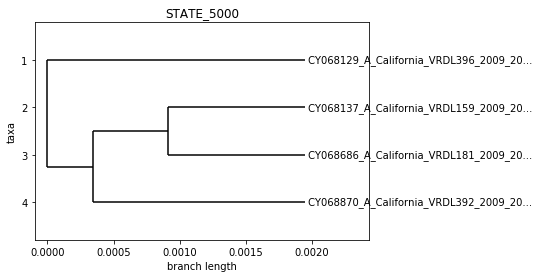

In [94]:
tree = trees[1]
Phylo.draw(tree)

In [95]:
def get_taxa(clade):
    return frozenset([leaf.name for leaf in clade.get_terminals()])
clade = list(tree.find_clades())[2]
clade.branch_length, get_taxa(clade)

(0.0003469073668290693,
 frozenset({'CY068137_A_California_VRDL159_2009_2009/04/28',
            'CY068686_A_California_VRDL181_2009_2009/04/28',
            'CY068870_A_California_VRDL392_2009_2009/04/28'}))

In [96]:
all_taxa = list(get_taxa(tree.root))
name_mapping = { name: str(i) for i, name in enumerate(all_taxa)}
name_mapping

{'CY068129_A_California_VRDL396_2009_2009/04/28': '1',
 'CY068137_A_California_VRDL159_2009_2009/04/28': '0',
 'CY068686_A_California_VRDL181_2009_2009/04/28': '2',
 'CY068870_A_California_VRDL392_2009_2009/04/28': '3'}

In [97]:
for tree in trees:
    for clade in tree.find_clades():
        if clade.name is not None:
            clade.name = name_mapping[clade.name]

list(tree.find_clades())

[Clade(branch_length=0.0),
 Clade(branch_length=0.002277814031265325, name='1'),
 Clade(branch_length=0.0003798014538035255),
 Clade(branch_length=0.0009167878028191378),
 Clade(branch_length=0.0009812247746426616, name='0'),
 Clade(branch_length=0.0009812247746426616, name='2'),
 Clade(branch_length=0.0018980125774617994, name='3')]

In [98]:
from tqdm import tqdm_notebook as tqdm

subclade_counts = {}

for tree in tqdm(trees):
    for clade in tree.find_clades():
        taxa = get_taxa(clade)
        if len(taxa) > 2:
            if taxa not in subclade_counts:
                subclade_counts[taxa] = {}
            conditional_split = Split(taxa, get_taxa(clade[0]))
            if conditional_split not in subclade_counts[taxa]:
                subclade_counts[taxa][conditional_split] = 1
            else:
                subclade_counts[taxa][conditional_split] += 1
subclade_counts

HBox(children=(IntProgress(value=0, max=1001), HTML(value='')))

{frozenset({'0', '2', '3'}): {Split({'3', '0', '2'}, {'0', '2'}): 236,
  Split({'3', '0', '2'}, {'3', '0'}): 88,
  Split({'3', '0', '2'}, {'0'}): 60},
 frozenset({'0', '1', '2'}): {Split({'2', '0', '1'}, {'0', '1'}): 106,
  Split({'1', '0', '2'}, {'0', '2'}): 233,
  Split({'1', '0', '2'}, {'0'}): 58},
 frozenset({'0', '1', '3'}): {Split({'3', '0', '1'}, {'0', '1'}): 26,
  Split({'3', '0', '1'}, {'3', '0'}): 40,
  Split({'3', '0', '1'}, {'0'}): 20},
 frozenset({'1', '2', '3'}): {Split({'3', '2', '1'}, {'2', '1'}): 17,
  Split({'2', '3', '1'}, {'3', '1'}): 5,
  Split({'2', '3', '1'}, {'1'}): 8},
 frozenset({'0',
            '1',
            '2',
            '3'}): {Split({'3', '2', '0', '1'}, {'2', '0', '1'}): 397, Split({'2', '3', '0', '1'}, {'3', '0', '1'}): 86, Split({'2', '3', '0', '1'}, {'0', '1'}): 26, Split({'3', '0', '2', '1'}, {'3', '0', '2'}): 384, Split({'3', '0', '2', '1'}, {'0', '2'}): 47, Split({'3', '0', '2', '1'}, {'3', '0'}): 31, Split({'3', '0', '2', '1'}, {'0'}): 30}}

In [107]:
sum(list(subclade_counts.values())[3].values())

86

In [113]:
import math

def normalise_dict_entries(dict_):
    sum_ = sum(dict_.values())
    return { key: value/sum_ for key, value in dict_.items() }

p = { clade: normalise_dict_entries(subclades) for clade, subclades in subclade_counts.items() }
p

{frozenset({'0',
            '2',
            '3'}): {Split({'3', '0', '2'}, {'0', '2'}): 0.6145833333333334, Split({'3', '0', '2'}, {'3', '0'}): 0.22916666666666666, Split({'3', '0', '2'}, {'0'}): 0.15625},
 frozenset({'0',
            '1',
            '2'}): {Split({'2', '0', '1'}, {'0', '1'}): 0.26700251889168763, Split({'1', '0', '2'}, {'0', '2'}): 0.5869017632241813, Split({'1', '0', '2'}, {'0'}): 0.14609571788413098},
 frozenset({'0',
            '1',
            '3'}): {Split({'3', '0', '1'}, {'0', '1'}): 0.3023255813953488, Split({'3', '0', '1'}, {'3', '0'}): 0.46511627906976744, Split({'3', '0', '1'}, {'0'}): 0.23255813953488372},
 frozenset({'1',
            '2',
            '3'}): {Split({'3', '2', '1'}, {'2', '1'}): 0.5666666666666667, Split({'2', '3', '1'}, {'3', '1'}): 0.16666666666666666, Split({'2', '3', '1'}, {'1'}): 0.26666666666666666},
 frozenset({'0',
            '1',
            '2',
            '3'}): {Split({'3', '2', '0', '1'}, {'2', '0', '1'}): 0.3966033966033

In [114]:
import pickle

with open('p.pickle', 'wb') as f:
    pickle.dump(p, f)